## Assignment: Group–Project 
**ITE 351: AI & Applications**

<u>**Group members:**</u>

[TODO]

## Introduction

### Imports

In [4]:
!pip install seaborn
!pip install scikit-learn

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.dates as mdates
import matplotlib.pyplot as plt

from collections import Counter

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score, roc_curve
from sklearn.model_selection import train_test_split


## Dataset

In [6]:
#Loading the csv file and get data
data = pd.DataFrame()
path_data_tesla = '../Datasets/Original/TSLA.csv'
trade_data_tesla = pd.read_csv(path_data_tesla ,sep = ',',)
trade_data_tesla.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,19.000000,25.000000,17.540001,23.889999,23.889999,18766300
1,2010-06-30,25.790001,30.420000,23.299999,23.830000,23.830000,17187100
2,2010-07-01,25.000000,25.920000,20.270000,21.959999,21.959999,8218800
3,2010-07-02,23.000000,23.100000,18.709999,19.200001,19.200001,5139800
4,2010-07-06,20.000000,20.000000,15.830000,16.110001,16.110001,6866900
5,2010-07-07,16.400000,16.629999,14.980000,15.800000,15.800000,6921700
6,2010-07-08,16.139999,17.520000,15.570000,17.459999,17.459999,7711400
7,2010-07-09,17.580000,17.900000,16.549999,17.400000,17.400000,4050600
8,2010-07-12,17.950001,18.070000,17.000000,17.049999,17.049999,2202500
9,2010-07-13,17.389999,18.639999,16.900000,18.139999,18.139999,2680100


In [7]:
def sort_datas(trade_data):
    """
    Rearranges columns in a DataFrame to get the same order.

    Parameters:
    trade_data (DataFrame): The input DataFrame containing trade-data from dataset

    Returns:
    DataFrame: A DataFrame with columns sorted as per the desired order.
    """

    #desired columns
    order = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
    
    #only select the disired columns from the given dataset
    selected_data = [col for col in order if col in trade_data.columns]
    trade_data = trade_data[selected_data]

    return trade_data


def combine_data(trade_datas):
    """
    Combines multiple DataFrames into one.
    Also checks if the coulmn features fit to each other

    Parameters:
    trade_datas (list): A list containing DataFrames that are going to be combined.

    Returns:
    DataFrame: A combined DataFrame containing all combined data

    Raises:
    ValueError: Error Message if the input DataFrames do not have a matching column structure.
    """
    #chekcing if trade_data is empty
    if len(trade_datas) == 0:
        return None
    
    #Retrieve columns of the first DataFrame in the list as reference columns
    ref_columns = list(trade_datas[0].columns)

    #ckecking if column features are matching
    for data in trade_datas[1:]:
        if list(data.columns) != ref_columns:
            raise ValueError("Wrong coloumn order")
    
    #create one DataFrame from combined data
    combined_data = pd.concat(trade_datas, ignore_index=True)
    return combined_data

In [8]:
def modify_data(trade_data, t_previous_days, t_label_days):
    """
    Modifies tehh trade dataset by several calculations and adding labels.
    This function is used to extend the dataset to find patterns more easily.

    Parameters:
    trade_data (DataFrame): Input DataFrame containing trade data information.
    t_previous_days (int): Number of previous days to consider for dataset expansion.
    t_label_days (int): Number of days concidered for labeling trade data.

    Returns:
    DataFrame: Modified DataFrame with calculated new features and labels.
   """
    
    #Define columns to be used for calculations
    columns_names = ['Open', 'High', 'Low', 'Close', 'Volume']

    # craete copy from DataFrame
    modified_trade_data = trade_data.copy()
    t_previous_days = 30

    # Calculate deviations from multiple features
    for attribute in columns_names:
        for i in range(1, t_previous_days + 1):
            deviation_col_name = f'deviation_{attribute}_{i}'
            modified_trade_data[deviation_col_name] = modified_trade_data[attribute] - modified_trade_data[attribute].shift(i)
            
            # Calculate average deviation for each feature
            average_deviation_col_name = f'average_deviation_{attribute}'
            modified_trade_data[average_deviation_col_name] = modified_trade_data[[f'deviation_{attribute}_{j}' for j in range(1, i + 1)]].mean(axis=1)

        # Calculate count of positive and negative deviations for each feature to see how often the value will rise or fall
        positive_deviation_col_name = f'positive_deviations_{attribute}'
        modified_trade_data[positive_deviation_col_name] = 0
        for i in range(1, t_previous_days + 1):
            modified_trade_data[positive_deviation_col_name] += (modified_trade_data[f'deviation_{attribute}_{i}'] > 0).astype(int)

        negative_deviation_col_name = f'negative_deviations_{attribute}'
        modified_trade_data[negative_deviation_col_name] = 0
        for i in range(1, t_previous_days + 1):
            modified_trade_data[negative_deviation_col_name] += (modified_trade_data[f'deviation_{attribute}_{i}'] < 0).astype(int)
    
    # Calculate differences between Open-Close and High-Low for several days
    for i in range(1, t_previous_days + 1):
        diff_col_name_open_close = f'difference_open_close_{i}'
        modified_trade_data[diff_col_name_open_close] = modified_trade_data['Open'] - modified_trade_data['Close'].shift(i)
        

        diff_col_name = f'difference_high_low_{i}'
        modified_trade_data[diff_col_name] = modified_trade_data[attribute] - modified_trade_data[attribute].shift(i)

    #Calculate average differences between Open-Close and High-Low for several days
    average_diff_col_name = f'average_difference_high_low'
    modified_trade_data[average_diff_col_name] = modified_trade_data[diff_col_name].rolling(window=t_previous_days).mean()
    average_diff_col_name_open_close = f'average_difference_open_close'
    modified_trade_data[average_diff_col_name_open_close] = modified_trade_data[diff_col_name_open_close].rolling(window=t_previous_days).mean()


    modified_trade_data.dropna(inplace=True)
    modified_trade_data.head()

    ######
    column_names = modified_trade_data.columns.tolist()
    
    modified_trade_data.dropna(inplace=True)

    # Create deviation and calculate average
    deviation_values = []
    for i in range(1, t_label_days + 1):
        deviation_col_name = f'deviation_{i}'
        modified_trade_data[deviation_col_name] = modified_trade_data['Low'].diff(i)
        deviation_values.append(modified_trade_data[deviation_col_name])


    average_deviation = sum(deviation_values) / t_label_days

    # Create labels based on deviation values
    modified_trade_data['Label'] = 0  # Initialisierung aller Labels als 0
    modified_trade_data = modified_trade_data[t_label_days:]
    average_deviation= average_deviation[t_label_days:]


    for index, deviation_value in average_deviation.items():
        
        if deviation_value < 0:
            modified_trade_data.loc[index, 'Label'] = 0
        else:
            modified_trade_data.loc[index, 'Label'] = 1

    modified_trade_data.head(20)
    return modified_trade_data


In [9]:
#number of days considered by the expansion of the dataset and creation of labels
t_previous_days = 1
t_label_days = 10

#modifiy the datasets and comnine them
modified = sort_datas(trade_data_tesla)
modified_trade_data_tesla_v1 = modify_data(modified, t_previous_days, t_label_days)
#TODO: add other datasets

/tmp/ipykernel_4222/2555088477.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  modified_trade_data[positive_deviation_col_name] = 0
/tmp/ipykernel_4222/2555088477.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  modified_trade_data[negative_deviation_col_name] = 0
/tmp/ipykernel_4222/2555088477.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To ge

In [4]:
# sns.set_theme(style="ticks")
# plot_kws = sns.pairplot(data=modified_trade_data_tesla_v1,  hue='label' ,palette="tab10")

/tmp/ipykernel_5456/1334267008.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  modified_trade_data[positive_deviation_col_name] = 0
/tmp/ipykernel_5456/1334267008.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  modified_trade_data[negative_deviation_col_name] = 0
/tmp/ipykernel_5456/1334267008.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To ge

In [ ]:
#repeating process for a comparison in a later stage
t_previous_days = 10
t_label_days = 10

#number of days considered by the expansion of the dataset and creation of labels
modified_trade_data_tesla_v2 = modify_data(modified, t_previous_days, t_label_days)

#modify and combine all datasets
#modified_trade_data = combine_data([modified_trade_data_tesla_v1, modified_trade_data_tesla_v1])


In [5]:
def plot_label_visualization(data):
    """
    Plots a visualization of labeled data.
    Used to ensure that the technique of labeling works correctly

    Parameters:
    data (DataFrame): DataFrame containing trade dartas
    """
    #convert dates into datetime format
    data['Date'] = pd.to_datetime(data['Date'])

    # Randomly select 3 data points for each label with 'Label 1' and 'Label 0'
    label_1_points = data[data['Label'] == 1].sample(n=3)
    label_0_points = data[data['Label'] == 0].sample(n=3)

    plt.figure(figsize=(8, 5))

    # Plot der data set
    plt.plot(data['Date'], data['Low'], label='Data', color='lightblue')
    plt.scatter(label_1_points['Date'], label_1_points['Low'], color='green', label='Label 1', s=100)
    plt.scatter(label_0_points['Date'], label_0_points['Low'], color='red', label='Label 0', s=100)

    # draws a vertical line to visualize desired time where the values rise or fall
    for idx, point in label_1_points.iterrows():
        plt.axvline(point['Date'] + pd.Timedelta(days=t_label_days), color='green', linestyle='--', alpha=0.7)
        
    for idx, point in label_0_points.iterrows():
        plt.axvline(point['Date'] + pd.Timedelta(days=t_label_days), color='red', linestyle='--', alpha=0.7)

    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('Low')
    plt.title('Prediction for an increase of value (Label = 1)')

    # Set x-axis to yearly intervals
    plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    plt.gcf().autofmt_xdate()

    plt.show()

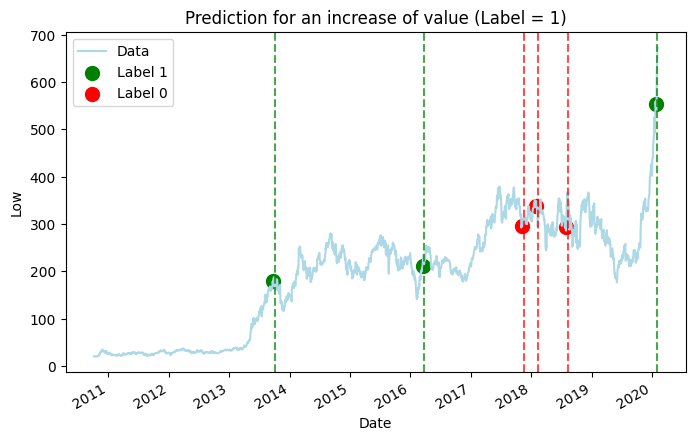

In [6]:
plot_label_visualization(modified_trade_data_tesla_v1)

## Methodology

In [12]:
def run_decision_tree_classifier_by_sklearn(modified_trade_data):
    """
    Running a decision tree classifier using scikit-learn library.

    Parameters:
    modified_trade_data (DataFrame): DataFrame containing modified trade- data

    Returns:
    tuple: A tuple containing decision tree model, predicted labels, accuracy score, and actual labels.
    """

    # Extract features and labels from givin modified_trade_data
    features = modified_trade_data.iloc[:, 1:-1]
    labels = modified_trade_data['Label']  # Das Label, das vorhergesagt werden soll
    
    # Split the dataset into training and testing data
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42)

    # Create a Decision Tree Classifier with sklearn
    decision_tree_model_sklearn = DecisionTreeClassifier(max_depth=10, min_samples_split=5)

    #train Desicion Tree model
    decision_tree_model_sklearn.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred_decision_tree_sklearn = decision_tree_model_sklearn.predict(X_test)

    # Evaluate model
    accuracy_decision_tree_sklearn = metrics.accuracy_score(y_test, y_pred_decision_tree_sklearn)
    return decision_tree_model_sklearn, y_pred_decision_tree_sklearn, accuracy_decision_tree_sklearn, y_test

In [13]:
#using the function run_decision_tree_classifier_by_sklearn() to create trained Desicion Tree Classifier with sklearn
decision_tree_model_sklearn_v1, y_pred_decision_tree_sklearn_v1, accuracy_decision_tree_sklearn_v1, y_test_dt_v1 = run_decision_tree_classifier_by_sklearn(modified_trade_data_tesla_v1)
decision_tree_model_sklearn_v2, y_pred_decision_tree_sklearn_v2, accuracy_decision_tree_sklearn_v2, y_test_dt_v2 = run_decision_tree_classifier_by_sklearn(modified_trade_data_tesla_v2)

In [15]:
def run_random_forest_classifier_by_sklearn(modified_trade_data):
    """
    Running a random forest classifier using scikit-learn library.

    Parameters:
    modified_trade_data (DataFrame): DataFrame containing modified trade data

    Returns:
    tuple: A tuple containing random forest model, predicted labels, accuracy score, and actual labels.
    """

    # Extract features and labels from the modified_trade_data
    features = modified_trade_data.iloc[:, 1:-1]
    labels = modified_trade_data['Label']  

    # Split the dataset into training and testing data
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42)

    # Build Random Forest model
    random_forest_model_sklearn = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10, min_samples_split=5)
    
    #Train Random Forest Model
    random_forest_model_sklearn.fit(X_train, y_train)

    # Test the model by predicting based on the test data
    y_pred_random_forest_sklearn = random_forest_model_sklearn.predict(X_test)

    # Evaluation  of the Random Forest model
    accuracy_random_forest_sklearn = accuracy_score(y_test, y_pred_random_forest_sklearn)
    return random_forest_model_sklearn, y_pred_random_forest_sklearn, accuracy_random_forest_sklearn, y_test

In [ ]:
random_forest_model_sklearn_v1, y_pred_random_forest_sklearn_v1, accuracy_random_forest_sklearn_v1, y_test_rf_v1 = run_random_forest_classifier_by_sklearn(modified_trade_data_tesla_v1)
random_forest_model_sklearn_v2, y_pred_random_forest_sklearn_v2, accuracy_random_forest_sklearn_v2, y_test_rf_v2 = run_random_forest_classifier_by_sklearn(modified_trade_data_tesla_v2)

### Models written in scratch

### Decision Tree written in scratch

In [18]:
class Tree_Node():
    def __init__(self, feature_index=None, threshold=None, branch_1=None, branch_2=None, improvment=None, value=None):
        """
        Initializes a tree node for the DecisionTree model

        Parameters:
        feature_index (int): Index of the feature used for splitting at this node.
        threshold (float): Threshold value for splitting the data at this node.
        branch_1 (Tree_Node): Subtree for data less than or equal to the threshold.
        branch_2 (Tree_Node): Subtree for data greater than the threshold.
        improvement (float): Information gain from the split at this node.
        value: Predicted class label if it is a leaf node.
        """
        self.feature_index = feature_index
        self.threshold = threshold
        self.branch_1 = branch_1
        self.branch_2= branch_2
        self.improvment = improvment
        self.value = value

class DecisionTree():
    def __init__(self, min_datas_branching=7, max_depth=10):
        """
        Initializes a Decision Tree classifier

        Parameters:
        min_datas_branching (int): Minimum number of data points required to create a new branch.
        max_depth (int): Maximum depth of the tree.
        """
        self.root = None        
        self.min_datas_branching = min_datas_branching
        self.max_depth = max_depth
        
    def create_tree(self, dataset, curr_depth=0):
        # Function to create a decision tree based on the dataset
        # Implementation using using recursion
        
        # Extract data and labels
        data = dataset[:,:-1]
        label = dataset[:,-1]
        number_of_datas, number_of_features = np.shape(data)

        # Conditions for stopping tree growth depending on max_depth and min_datas_branching 
        if number_of_datas>self.min_datas_branching and curr_depth<=self.max_depth and number_of_datas > number_of_features:
            best_branching = self.get_best_branching(dataset, number_of_datas, number_of_features)

            if best_branching["improvment"]>0: #if ==0, the node only consists of one type of class
                branch_1_subtree = self.create_tree(best_branching["dataset_branch_1"], curr_depth+1)
                branch_2_subtree = self.create_tree(best_branching["dataset_branch_2"], curr_depth+1)
                return Tree_Node(best_branching["feature_index"], best_branching["threshold"], branch_1_subtree, branch_2_subtree, best_branching["improvment"])
        
        # Creating a leaf node if stopping conditions are fullfilled
        leaf_value = self.calculate_leaf_value(label)
        return Tree_Node(value=leaf_value)
    
    def get_best_branching(self, dataset, number_of_datas, number_of_features):
        """
        Finds the best split for branching the tree based on value of information gain.

        Parameters:
        dataset (array-like): Input dataset.
        number_of_datas (int): Number of data points in the dataset.
        number_of_features (int): Number of features in the dataset.

        Returns:
        dict: Dictionary containing information about the best branching.
        """
        best_branching = {}
        max_improvment = -float("inf") 

        # Loop through each feature to find the best split of the tree
        for feature_index in range(number_of_features):
            feature_values = dataset[:, feature_index]
            possible_thresholds = np.unique(feature_values)

            # Iterate through possible thresholds for the current feature
            for threshold in possible_thresholds:
                # Split the dataset based on the current feature and threshold
                dataset_branch_1, dataset_branch_2= self.branch_tree(dataset, feature_index, threshold)
                # Check if both branches have data points
                if len(dataset_branch_1)>0 and len(dataset_branch_2)>0:
                    label, label_branch_1, label_branch_2 = dataset[:, -1], dataset_branch_1[:, -1], dataset_branch_2[:, -1]
                    
                    # Calculating the information gain using Gini index
                    new_improvment = self.information_gain(label, label_branch_1, label_branch_2, "gini")

                    # Update the best branching if the improvement is greater
                    if new_improvment>max_improvment:
                        best_branching["feature_index"] = feature_index
                        best_branching["threshold"] = threshold
                        best_branching["dataset_branch_1"] = dataset_branch_1
                        best_branching["dataset_branch_2"] = dataset_branch_2
                        best_branching["improvment"] = new_improvment
                        max_improvment = new_improvment
        return best_branching
    
    def branch_tree(self, dataset, feature_index, threshold):
        """
        Splits the dataset into two branches based on a given feature and threshold.

        Parameters:
        dataset (array-like): Input dataset.
        feature_index (int): Index of the feature to split.
        threshold (float): Threshold value for splitting the data.

        Returns:
        tuple: Two arrays representing datasets split into two branches.
        """
        dataset_branch_1 = np.array([row for row in dataset if row[feature_index]<=threshold])
        dataset_branch_2= np.array([row for row in dataset if row[feature_index]>threshold])
        return dataset_branch_1, dataset_branch_2
    
    def information_gain(self, parent, l_child, r_child, mode="entropy"):
        """
        Calculating information gain for a split based on Gini index or entropy.
        Both type of calculation possible but only one used.

        Parameters:
        parent (array-like): Labels of the parent node.
        l_child (array-like): Labels of the left child node.
        r_child (array-like): Labels of the right child node.
        mode (str): Mode for calculating gain, either 'gini' or 'entropy'.

        Returns:
        float: Information gain.
        """
        weight_branch_a = len(l_child) / len(parent)
        weight_branch_b = len(r_child) / len(parent)
        if mode=="gini":
            gain = self.gini_index(parent) - (weight_branch_a*self.gini_index(l_child) + weight_branch_b*self.gini_index(r_child))
        else:
            gain = self.entropy(parent) - (weight_branch_a*self.entropy(l_child) + weight_branch_b*self.entropy(r_child))
        return gain
    
    def entropy(self, y):   
        """
        Calculates entropy of a set of labels.

        Parameters:
        y (array-like): Labels.

        Returns:
        float: Entropy value.
        """     
        class_labels = np.unique(y)
        entropy = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            entropy += -p_cls * np.log2(p_cls)
        return entropy
    
    def gini_index(self, y):   
        """
        Calculates Gini index of a set of labels.

        Parameters:
        y (array-like): Labels.

        Returns:
        float: Gini index value.
        """  
        class_labels = np.unique(y)
        gini = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            gini += p_cls**2
        return 1 - gini
        
    def calculate_leaf_value(self, label):
        """
        Calculates the predicted leaf value based on a majority voting.

        Parameters:
        label (array-like): Labels.

        Returns:
        int: Predicted value for the leaf node.
        """
        label = list(label)
        return max(label, key=label.count)
    
    
    def fit(self, data, label):
        """
        Train the Decision Tree with provided data and labels.

        Parameters:
        data (array-like): Input data.
        label (array-like): Target labels.
        """
        label_array = label.reshape(-1, 1)
        dataset = np.concatenate((data, label_array), axis=1)

        self.root = self.create_tree(dataset)
    
    def predict(self, data): 
        """
        Predicts labels based on the given data.

        Parameters:
        data (array-like): Input data.

        Returns:
        list: Predicted labels for the input data.
        """
        preditions = [self.make_prediction(x, self.root) for x in data]
        return preditions
    
    def make_prediction(self, x, tree):
        """
        Makes predictions for a single data point using the decision tree.

        Parameters:
        x (array-like): Single data point for prediction.
        tree (Tree_Node): Current tree node.

        Returns:
        Predicted label for the input data point.
        """
        if tree.value!=None: return tree.value
        
        feature_val = x[tree.feature_index]
        if feature_val<=tree.threshold:
            return self.make_prediction(x, tree.branch_1)
        else:
            return self.make_prediction(x, tree.branch_2)


In [19]:
modified_trade_data_tesla_v1.head()

,Date,Open,High,Low,Close,Volume,deviation_Open_1,average_deviation_Open,deviation_Open_2,deviation_Open_3,...,deviation_2,deviation_3,deviation_4,deviation_5,deviation_6,deviation_7,deviation_8,deviation_9,deviation_10,Label
69,2010-10-06,21.059999,21.260000,20.320000,20.459999,313400,-0.090001,0.525332,0.629999,0.369998,...,0.020001,0.010001,0.129999,-0.809999,-0.440000,0.270001,0.670000,0.820000,0.520001,1
70,2010-10-07,20.570000,20.639999,20.340000,20.430000,141000,-0.489999,-0.025000,-0.580000,0.140000,...,-0.670000,0.040001,0.030001,0.149999,-0.789999,-0.420000,0.290001,0.690000,0.840000,1
71,2010-10-08,20.430000,20.790001,20.389999,20.430000,267800,-0.140000,-0.212000,-0.629999,-0.720000,...,0.069999,-0.620001,0.090000,0.080000,0.199998,-0.740000,-0.370001,0.340000,0.739999,0
72,2010-10-11,20.440001,20.700001,20.070000,20.240000,171200,0.010001,-0.219999,-0.129999,-0.619998,...,-0.270000,-0.250000,-0.940000,-0.229999,-0.239999,-0.120001,-1.059999,-0.690000,0.020001,0
73,2010-10-12,20.200001,20.280001,20.030001,20.240000,244000,-0.240000,-0.482999,-0.229999,-0.369999,...,-0.359998,-0.309999,-0.289999,-0.979999,-0.269998,-0.279998,-0.160000,-1.099998,-0.729999,0


In [20]:
def run_decision_tree_from_scratch(modified_trade_data):
    """
    Runs a decision tree classifier implemented from scratch using the provided modified trade data.

    Parameters:
    modified_trade_data (DataFrame): DataFrame containing modified trade data.

    Returns:
    tuple: A tuple containing the decision tree model, predicted labels, accuracy score, and actual labels.
    """
    # Extracting features and labels from the modified_trade_data
    features = modified_trade_data.iloc[:, 1:-1].values

    labels = modified_trade_data.iloc[:, -1].values.reshape(-1,1)
    labels = modified_trade_data['Label']

    # Splitting the dataset into training and testing sets
    X_train, X_test, y_train, y_test_scratch_dt = train_test_split(features, labels, test_size=0.3, random_state=42)

    # Initialize and train the decision tree model from scratch
    decision_tree_model_scratch = DecisionTree(min_datas_branching=5, max_depth=7)
    y_train = y_train.to_numpy()
    decision_tree_model_scratch.fit(X_train,y_train)

    # Make predictions using the fitted model
    decision_tree_model_scratch.fit(X_train,y_train)
    y_pred_decision_tree_scratch = decision_tree_model_scratch.predict(X_test)

     # Calculate accuracy of the model
    accuracy_decision_tree_scratch = metrics.accuracy_score(y_test_scratch_dt, y_pred_decision_tree_scratch)
    return decision_tree_model_scratch, y_pred_decision_tree_scratch, accuracy_decision_tree_scratch, y_test_scratch_dt

In [21]:
#Using the fuction run_decision_tree_from_scratch() to craete and get Decision Tree model implemented from scratch
decision_tree_model_scratch_v1, y_pred_decision_tree_scratch_v1, accuracy_decision_tree_scratch_v1, y_test_scratch_dt_v1 = run_decision_tree_from_scratch(modified_trade_data_tesla_v1)
decision_tree_model_scratch_v2, y_pred_decision_tree_scratch_v2, accuracy_decision_tree_scratch_v2, y_test_scratch_dt_v2 = run_decision_tree_from_scratch(modified_trade_data_tesla_v2)

### random forest scratch

In [23]:
class RandomForest:
    def __init__(self, n_trees, max_depth=7, min_datas_branching=5, n_feature=None):
        """
        Initializes the RandomForest model implemented from scratch.

        Parameters:
        n_trees (int): Number of trees in the random forest.
        max_depth (int): Maximum depth of each decision tree.
        min_datas_branching (int): Minimum number of data points required for branching.
        n_feature (int): Number of features to consider for each tree.
        """
        self.n_trees = n_trees
        self.max_depth=max_depth
        self.min_datas_branching=min_datas_branching
        self.n_features=n_feature
        self.trees = []

    def fit(self, X, y):
        """
        Fits the RandomForest model with the given input data.

        Parameters:
        X (array-like): Input features.
        y (array-like): Target labels.
        """
        self.trees = []
        for _ in range(self.n_trees):
            # Create a decision tree and train it using a subset of the data
            tree = DecisionTree(max_depth=self.max_depth,
                            min_datas_branching=self.min_datas_branching)
            X_sample, y_sample = self.samples(X, y)
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

    def samples(self, X, y):
        """
        Generates random samples for training each tree in the forest.

        Parameters:
        X (array-like): Input features.
        y (array-like): Target labels.

        Returns:
        tuple: Sampled features and labels.
        """
        n_samples = X.shape[0]
        label_samples = y.to_numpy()
        index = np.random.choice(n_samples, size=n_samples, replace=True)
        return X[index], label_samples[index]
    
    def identify_most_common(self, y):
        """
        Identifies the most common label in a given set of labels.

        Parameters:
        y (array-like): Labels.

        Returns:
        int: Most common label.
        """
        counter = Counter(y)
        most_common_prediction = counter.most_common(1)[0][0]
        return most_common_prediction

    def predict(self, X):
        """
        Predicts the label using the RandomForest model written by scratch

        Parameters:
        X (array-like): Input features for prediction.

        Returns:
        array-like: Predicted labels.
        """
        predictions = np.array([tree.predict(X) for tree in self.trees])
        tree_preds = np.swapaxes(predictions, 0, 1)
        predictions = np.array([self.identify_most_common(pred) for pred in tree_preds])
        return predictions

In [24]:
def run_random_forest_from_scratch(modified_trade_data):
    """
    Trains and evaluates a random forest classifier implemented from scratch using modified trade data.

    Parameters:
    modified_trade_data (DataFrame): DataFrame containing modified trade data

    Returns:
    tuple: A tuple containing the random forest model, predicted labels, accuracy score, and actual labels.
    """
    # Extracting features and labels from the modified_trade_data
    features = modified_trade_data.iloc[:, 1:-1].values
    labels = modified_trade_data.iloc[:, -1].values.reshape(-1,1)
    labels = modified_trade_data['Label']
    
    # Splitting the dataset into training and testing data
    X_train, X_test, y_train, y_test_scratch_rf = train_test_split(features, labels, test_size=0.3, random_state=42)
   
    # Initialize and train the random forest model from scratch
    random_forest_model_scratch = RandomForest(n_trees  = 100 )
    random_forest_model_scratch.fit(X_train,y_train)

    # Make predictions using the fitted model
    y_pred_random_forest_scratch = random_forest_model_scratch.predict(np.array(X_test))
    
    # Calculate accuracy of the model
    accuracy_random_forest_scratch = metrics.accuracy_score(y_test_scratch_rf, y_pred_random_forest_scratch)
    return random_forest_model_scratch, y_pred_random_forest_scratch, accuracy_random_forest_scratch, y_test_scratch_rf

In [25]:
#Using the fuction run_random_forest_from_scratch() to craete and get Random Forest model implemented from scratch

random_forest_model_scratch_v1, y_pred_random_forest_scratch_v1, accuracy_random_forest_scratch_v1, y_test_scratch_rf_v1 = run_random_forest_from_scratch(modified_trade_data_tesla_v1)
random_forest_model_scratch_v2, y_pred_random_forest_scratch_v2, accuracy_random_forest_scratch_v2, y_test_scratch_rf_v2 = run_random_forest_from_scratch(modified_trade_data_tesla_v2)

KeyboardInterrupt: 

## Evaluation & Analysis

There are different ways of analysing the model of an artificial intelligence. In this project work, the project work focusses on the determined accuracy and the ROC curve. On the one hand, the self-programmed models and the models from sklearn are compared. Subsequently, the training of the models is repeated with changed parameters when modifying the data set. The number of days set for expanding the data set and creating the label is varied.

[TODO: Result]

### Accuracys

#### Modification with ... days before the data point and ... days after for labeling

In [26]:
#printing accuracys
print("Accuracy from Decision Tree: ", accuracy_decision_tree_sklearn_v1)
print("Accuracy from Random Forest: ", accuracy_random_forest_sklearn_v1)

Accuracy from Decision Tree:  0.9375886524822695


NameError: name 'accuracy_random_forest_sklearn_v1' is not defined

In [28]:
#printing accuracys
print("Accuracy from Decision Tree coded in scratch: ", accuracy_decision_tree_scratch_v1)
print("Accuracy from Random Forest coded in scratch: ", accuracy_random_forest_scratch_v2)

Accuracy from Decision Tree coded in scratch:  0.9106382978723404


NameError: name 'accuracy_random_forest_scratch_v2' is not defined

#### Modification with ... days before the data point and ... days after for labeling

In [27]:
#printing accuracys
print("Accuracy from Decision Tree: ", accuracy_decision_tree_sklearn_v2)
print("Accuracy from Random Forest: ", accuracy_random_forest_sklearn_v2)

Accuracy from Decision Tree:  0.9347517730496454


NameError: name 'accuracy_random_forest_sklearn_v2' is not defined

In [29]:
#printing accuracys
print("Accuracy from Decision Tree coded in scratch: ", accuracy_decision_tree_scratch_v2)
print("Accuracy from Random Forest coded in scratch: ", accuracy_random_forest_scratch_v2)

Accuracy from Decision Tree coded in scratch:  0.9106382978723404


NameError: name 'accuracy_random_forest_scratch_v2' is not defined

[TODO]

Train more models

### ROC

#### Modification with ... days before the data point and ... days after for labeling

In [30]:
def plot_roc(label, Y_test, Y_pred):
    """
    Plots the Receiver Operating Characteristic (ROC) curve for model evaluation.

    Parameters:
    label (str): Label for the curve.
    Y_test (array-like): True labels.
    Y_pred (array-like): Predicted probabilities or scores.

    Returns:
    None
    """

    fpr, tpr, _ =  roc_curve(Y_test, Y_pred)
    plt.plot(fpr,tpr, label=label)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')

NameError: name 'y_test_rf_v1' is not defined

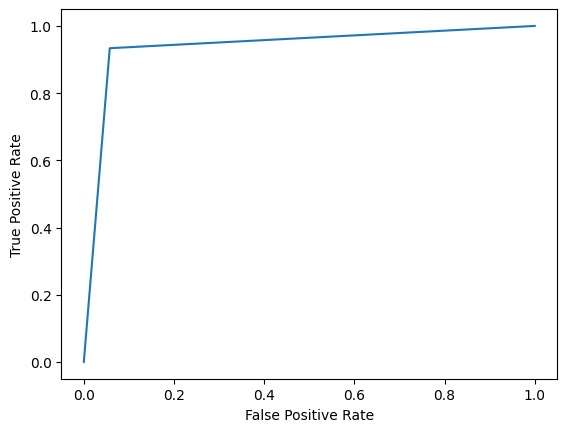

In [31]:
plot_roc('Decision Tree', y_test_dt_v1, y_pred_decision_tree_sklearn_v1)
plot_roc('Random Forest', y_test_rf_v1, y_pred_random_forest_sklearn_v1)
plt.legend()
plt.title('ROC -Models from sklearn')
plt.show()

NameError: name 'y_test_scratch_rf_v1' is not defined

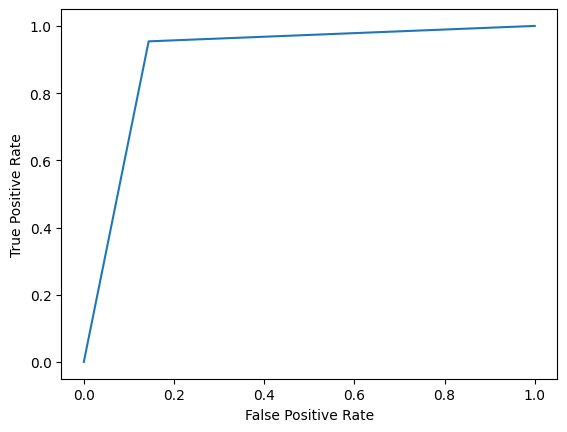

In [32]:
#plot ROCs for models implemented by scratch
plot_roc('Decision Tree', y_test_scratch_dt_v1, y_pred_decision_tree_scratch_v1)
plot_roc('Random Forest', y_test_scratch_rf_v1, y_pred_random_forest_scratch_v1)
plt.legend()
plt.title('ROC - Models from scratch')
plt.show()

#### Modification with ... days before the data point and ... days after for labeling

[TODO]

NameError: name 'y_test_rf_v2' is not defined

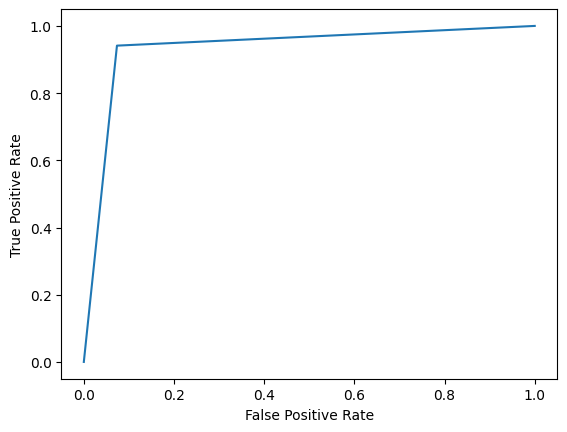

In [33]:
#plot ROCs for models bild with sklearn

plot_roc('Decision Tree', y_test_dt_v2, y_pred_decision_tree_sklearn_v2)
plot_roc('Random Forest', y_test_rf_v2, y_pred_random_forest_sklearn_v2)
plt.legend()
plt.title('ROC -Models from sklearn')
plt.show()

NameError: name 'y_test_scratch_rf_v2' is not defined

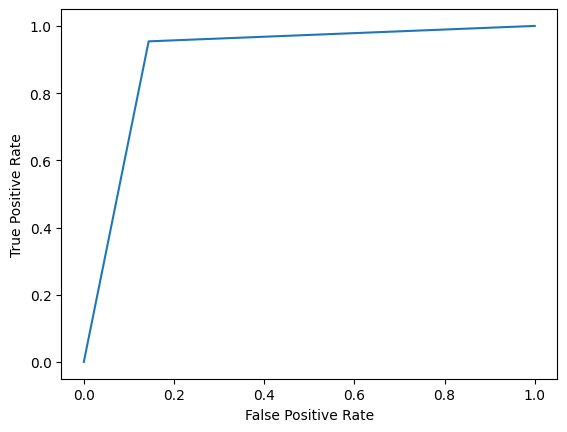

In [34]:
#plot ROCs for models implemented by scratch
plot_roc('Decision Tree', y_test_scratch_dt_v2, y_pred_decision_tree_scratch_v2)
plot_roc('Random Forest', y_test_scratch_rf_v2, y_pred_random_forest_scratch_v2)
plt.legend()
plt.title('ROC - Models from scratch')
plt.show()

## Related Work

## Conclusion